In [10]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from quantstats.stats import sharpe
from utils.func import center
import matplotlib.pyplot as plt

In [9]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()

In [55]:
DATA = pd.read_parquet('data/US/STRAT_EARNINGS/')
DATA.drop('SnpDate',axis=1,inplace=True)
DATA = DATA.set_index(['Date','Ticker'])
DATA = DATA['SIGNAL'].unstack()


C:\Users\marti\AppData\Local\Temp\ipykernel_26536\380981398.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)
C:\Users\marti\AppData\Local\Temp\ipykernel_26536\380981398.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  pnl = (signal[P].shift(1)*R).dropna(0,'all').sum(1)


Sharpe      0.5
Turnover    0.2
biais       0.4
dtype: float64

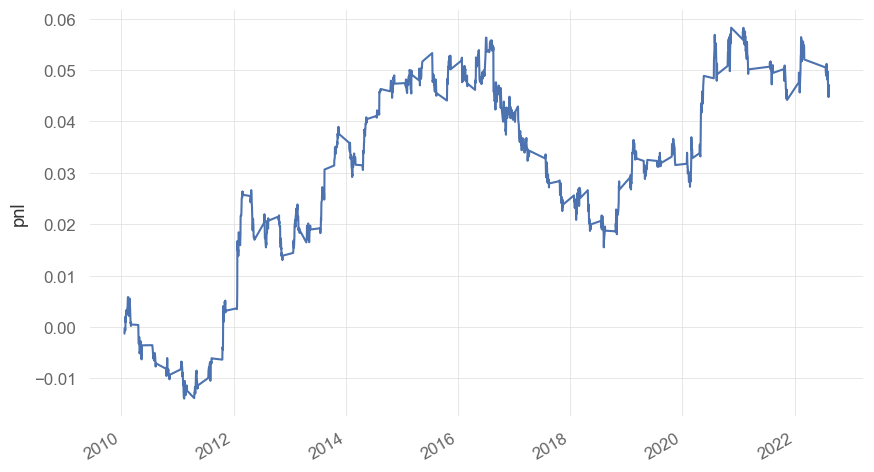

In [56]:
signal =DATA.copy()
signal = signal.rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
# signal = signal.rolling(252).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal = signal.reindex_like(P)[P].ffill(limit=5)
signal[signal.abs()<0.5] = None
signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)
signal = signal[P].div(signal.abs().sum(1),0)
pnl = (signal[P].shift(1)*R).dropna(0,'all').sum(1)
sr = sharpe(pnl)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
pnl.cumsum().plot()
plt.ylabel('pnl')
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl.mean()*1e4}).round(1)